Dataset: **Neurotech@Rice Datathon Challenge**  

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/xavier/PycharmProjects/sleep-linear/src/")

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data from Google Drive

# Create dataloader

In [5]:
common_signals = [
    'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal',  # All have the same sampling rate (100 Hz)
    'Resp oro-nasal',
    'Resp oro-nasal rate',
    'EMG submental',  # Also 100 Hz
    'Temp rectal',
]

def load_edf(file_path:str):
    X = np.load(file_path)
    X = np.hstack(X)
    index_X = pd.date_range(start=0, periods=X.shape[1], freq=pd.Timedelta(1 / 100, unit="s"))
    data = []
    cnt = 0
    for i in range(X.shape[0]):
        data.append(pd.Series(X[i, :], index=index_X, name=common_signals[cnt]))
        cnt += 1
        if i == 3:
            rate = np.diff(X[i, :])
            data.append(pd.Series(np.append(rate, rate[-1]), index=index_X, name=common_signals[cnt]))
            cnt += 1
    return data

def load_label(file_path: str):
    y = np.load(file_path)
    index_y = pd.date_range(start=0, periods=y.shape[0], freq=pd.Timedelta(30, unit="s"))
    annotations = pd.Series(y, index=index_y)
    return annotations


def labels_to_30s(labels):
    index = labels.index
    values = [cats[int(val)] for val in annotations.values]
    return pd.DataFrame({"label": values}, index=index)

## Load some data

In [6]:
data_folder = "/home/xavier/PycharmProjects/sleep-linear/data/Neurotech@Rice Datathon Challenge"

os.listdir(data_folder)
training_set = f"{data_folder}/Training [NEW]"
items = [item.split('NEW')[0] for item in os.listdir(training_set)]
items = np.unique(items)
items.sort()
signal_files = []
for item in items:
    if not os.path.exists(f"{training_set}/{item}NEW_X.npy") or not os.path.exists(f"{training_set}/{item}NEW_y.npy"):
        print(f"{item} is missing!")
    else:
        signal_info = (item[1:3], item[5:6], f"{item}NEW_X.npy", f"{item}NEW_y.npy")
        signal_files.append(signal_info)
signal_files = sorted(signal_files, key=lambda x: (x[0], x[1]))
df_files = pd.DataFrame(signal_files, columns=["patient_id", "night_id", "edf_file", "label_file"])
df_files

p10_n2_ is missing!
p11_n1_ is missing!


,patient_id,night_id,edf_file,label_file
0,00,1,p00_n1_NEW_X.npy,p00_n1_NEW_y.npy
1,00,2,p00_n2_NEW_X.npy,p00_n2_NEW_y.npy
2,01,1,p01_n1_NEW_X.npy,p01_n1_NEW_y.npy
3,02,1,p02_n1_NEW_X.npy,p02_n1_NEW_y.npy
4,02,2,p02_n2_NEW_X.npy,p02_n2_NEW_y.npy
5,03,1,p03_n1_NEW_X.npy,p03_n1_NEW_y.npy
6,03,2,p03_n2_NEW_X.npy,p03_n2_NEW_y.npy
7,04,1,p04_n1_NEW_X.npy,p04_n1_NEW_y.npy
8,04,2,p04_n2_NEW_X.npy,p04_n2_NEW_y.npy
9,05,1,p05_n1_NEW_X.npy,p05_n1_NEW_y.npy


=> In total 41 files (41 EDF files - 41 hypnogram files) 

In [7]:
df_files.patient_id.nunique()

23

In [8]:
df_files.edf_file.nunique()

41

=> edf file can be used as recordingid   
=> patient id can be used as patient id 

In [9]:
idx = 0
data = load_edf(f"{training_set}/{df_files.iloc[idx].edf_file}")
annotations = load_label(f"{training_set}/{df_files.iloc[idx].label_file}")


In [92]:
# Used for plotting
cats = [
    "Sleep stage ?",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]
cats_rev = {
    "Sleep stage ?": 0,
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6,
}

# EDA + pipeline (for 1 patient)

In [11]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs  + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=3_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[], y=[], name=s.name, line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )


y_ticks = pd.Series([cats[int(val)] for val in annotations.values])

fig.add_trace(
    go.Scattergl(
        x=[], y=[], name="Hypnogram", line_width=1.5, line_shape="hv",
    ),
    hf_x=annotations.index,
    hf_y=y_ticks.astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=1600)
fig.update_yaxes(categoryorder="array", categoryarray=cats)
# 
fig.update_layout(
    legend_traceorder="normal",
    template="plotly_white",
    legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8043)

## Process the signals

In [12]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

def temp_normalize(temp):
    return temp - np.mean(temp)

eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

resp_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["Resp oro-nasal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EMG submental"],
    lowcut=0.5,
    highcut=10,
    fs=100,
)

temp_normal = SeriesProcessor(
    function=temp_normalize,
    series_names=["Temp rectal"]
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass, resp_bandpass,
        emg_bandpass, temp_normal
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('Resp oro-nasal',)
	butter_bandpass_filter {'lowcut': 0.5, 'highcut': 10, 'fs': 100} :  ('EMG submental',)
	temp_normalize {} :  ('Temp rectal',)
]

In [13]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: user 332 ms, sys: 40.2 ms, total: 372 ms
Wall time: 371 ms


In [14]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )
    
fig.show_dash(port=8043)

## Extract the features

In [15]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [19]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower
import scipy

from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

def compute_differences(a):
    ans = [a[i+1] - a[i] for i in range(len(a) - 1)]
    ans.append(ans[-1])
    return ans

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "Resp oro-nasal", "Resp oro-nasal rate", "EMG submental", "Temp rectal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "Resp oro-nasal", "Resp oro-nasal rate"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])



In [20]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)


In [21]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/456 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=1m30s,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=1m30s,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,...,Temp rectal__petrosian_fd__w=30s,Temp rectal__skew__w=1m,Temp rectal__skew__w=1m30s,Temp rectal__skew__w=30s,Temp rectal__std__w=1m,Temp rectal__std__w=1m30s,Temp rectal__std__w=30s,Temp rectal__wrapped_higuchi_fd__w=1m,Temp rectal__wrapped_higuchi_fd__w=1m30s,Temp rectal__wrapped_higuchi_fd__w=30s
1970-01-01 00:00:30,NaN,NaN,0.0,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,1.000399,NaN,NaN,1.314915,NaN,NaN,0.032219,NaN,NaN,1.002079
1970-01-01 00:01:00,0.0,NaN,0.0,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,1.000399,1.209125,NaN,-0.554347,0.028907,NaN,0.020477,1.002397,NaN,1.002994
1970-01-01 00:01:30,0.0,0.0,0.0,0.032559,0.0239,0.032287,0.03873,0.027223,0.027552,1.564244,...,1.000399,-0.417293,1.170491,-0.033039,0.019647,0.025736,0.017724,1.001327,1.001534,1.000650
1970-01-01 00:02:00,0.0,0.0,0.0,0.056282,0.041142,0.074854,0.03516,0.036783,0.028251,1.431736,...,1.000366,0.000577,-0.305821,0.033640,0.017951,0.019257,0.018172,1.001575,1.001712,1.002209
1970-01-01 00:02:30,0.0,0.0,0.0,0.068842,0.063116,0.059463,0.027978,0.034582,0.027121,1.376963,...,1.000333,0.045276,0.027705,-0.232178,0.017217,0.017502,0.015298,1.003612,1.002642,1.003850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 22:02:30,0.0,0.0,0.0,0.036642,0.025157,0.030919,0.047035,0.031875,0.034681,1.535747,...,1.000366,-0.271455,-0.185573,-0.233972,0.015288,0.015200,0.015138,1.001896,1.002050,1.002863
1970-01-01 22:03:00,0.0,0.0,0.0,0.035044,0.036785,0.035758,0.040611,0.047695,0.051777,1.621815,...,1.000432,-0.090801,-0.160025,0.058616,0.015559,0.015496,0.015782,1.002823,1.002315,1.001943
1970-01-01 22:03:30,0.0,0.0,0.0,0.036019,0.031562,0.026256,0.047291,0.039144,0.034697,1.413289,...,1.000432,0.237396,0.062983,0.466568,0.016579,0.016385,0.016858,1.002761,1.003077,1.003533
1970-01-01 22:04:00,0.0,0.0,0.0,0.037448,0.038002,0.047466,0.042533,0.044301,0.047973,1.410208,...,1.000432,0.098357,0.080187,-0.210268,0.016296,0.016156,0.014847,1.002055,1.002005,1.000359


# Pipeline for all patients

In [22]:
from tqdm.auto import tqdm

df_feats = []
for edf_file, hypnogram_file in tqdm(zip(df_files.edf_file, df_files.label_file)):
    # Load the data, process the data and extract features
    data = load_edf(f"{training_set}/{edf_file}")
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_label(f"{training_set}/{hypnogram_file}")
    annotations = labels_to_30s(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["edf_file"] = edf_file
    df_feat["patient_id"] = edf_file[1:3]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:

invalid value encountered in divide

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:

invalid value encountered in divide

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:

invalid value encountered in divide

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:

invalid value encountered in divide

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:

invalid value encountered in divide

/home/xavier/anaconda3/envs/sleep2/lib/python3.9/site-packages/tsfresh/feature_extraction/feature_calculators.py:1804: RuntimeWarning:


In [23]:
df_feats.to_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf_ALL__90s.parquet")

## Load data

In [24]:
df_feats = pd.read_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf_ALL__90s.parquet")
df_feats.shape

(112535, 633)

In [25]:
df_feats["label"].value_counts()

Sleep stage W    77110
Sleep stage 2    18464
Sleep stage R     8025
Sleep stage 1     3286
Sleep stage 3     3255
Sleep stage 4     2295
Sleep stage ?      100
Name: label, dtype: int64

In [26]:
df_feats[~df_feats.edf_file.isin(df_files.edf_file.unique())].edf_file.nunique()

0

In [27]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112535 entries, 1970-01-01 00:00:00 to 1970-01-01 22:52:00
Columns: 633 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(630), object(3)
memory usage: 273.9+ MB


In [28]:
eeg_signals = [d.name for d in data_processed if "EEG" in d.name]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(112535, 663)

In [29]:
skip_cols = ["edf_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [30]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if f.endswith("w=1m")]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for edf_file in df_feats.edf_file.unique():
    sub_df = df_feats[df_feats.edf_file == edf_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

220 220 220


(112535, 1763)

In [31]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112535 entries, 1970-01-01 00:00:00 to 1970-01-01 22:52:00
Columns: 1763 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(1760), object(3)
memory usage: 759.0+ MB


In [32]:
# Postprocess labels
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [33]:
df_feats.shape

(112435, 1763)

In [34]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for edf_file in df_feats["edf_file"].unique():
    sub_df = df_feats[df_feats.edf_file == edf_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs

In [35]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()


44709


Sleep stage 2    18464
Sleep stage W     9384
Sleep stage R     8025
Sleep stage 1     3286
Sleep stage 3     3255
Sleep stage 4     2295
Name: label, dtype: int64

### Look into nan features

In [36]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

443

In [37]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.edf_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

Series([], dtype: float64)

In [38]:
df_feats_trimmed_all["edf_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

Series([], Name: edf_file, dtype: int64)

In [39]:
for edf_file in df_feats_trimmed_all.edf_file.unique():
    assert not df_feats_trimmed_all[df_feats_trimmed_all.edf_file == edf_file].isna().any(axis=1)[2:-2].any()

In [40]:
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats_trimmed_all)

0.0

=> No feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values are only present at the start and end of the file (in the first two and last two epochs -> when there is not enough data to calculate a larger window features (90s, 60s)).


## EDA on labels

<Axes: >

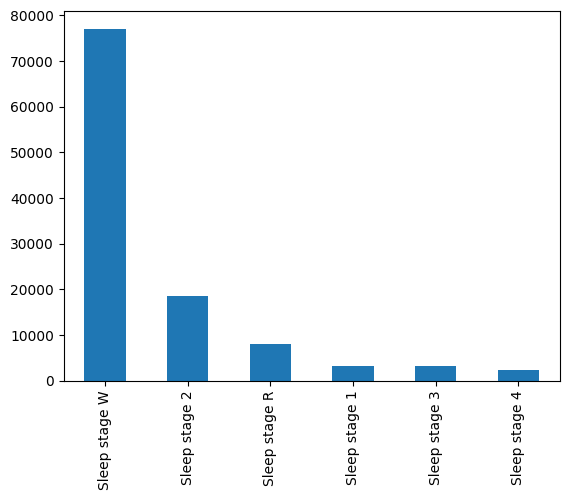

In [41]:
df_feats["label"].value_counts().plot(kind="bar")

<Axes: >

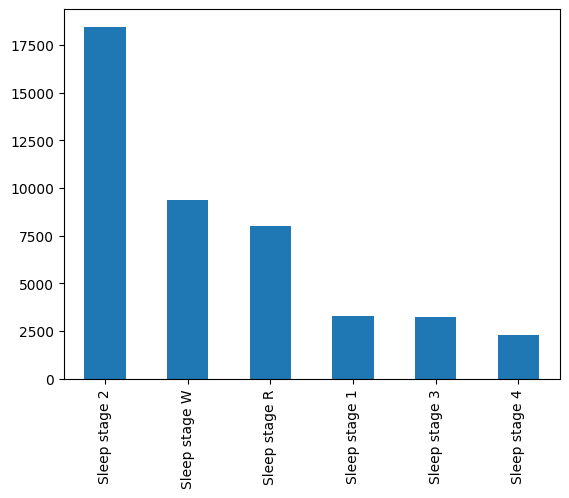

In [42]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")

In [43]:
df_feats_trimmed_all["label"].value_counts()


Sleep stage 2    18464
Sleep stage W     9384
Sleep stage R     8025
Sleep stage 1     3286
Sleep stage 3     3255
Sleep stage 4     2295
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [44]:
skip_cols = ["edf_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [45]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()

# ML

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [47]:
from src.visualizations import plot_linear_classification_coefs
from src.visualizations import plot_learning_curve
from src.visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [48]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

## MLP pipeline

In [101]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "MLP",
            MLPClassifier(
                hidden_layer_sizes=1000,
                random_state=0,
            ),
        ),
    ]
)

In [ ]:
### Fit the pipeline
pipe.fit(df_feats_trimmed_all[feat_cols], df_feats_trimmed_all["label"])

In [50]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed_all[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_all[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_all["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_all["label"], y_pred=preds))

Training data:
Log loss: 0.7288051177870752
               precision    recall  f1-score   support

Sleep stage 1       0.55      0.65      0.60      3286
Sleep stage 2       0.92      0.88      0.90     18464
Sleep stage 3       0.66      0.75      0.70      3255
Sleep stage 4       0.83      0.86      0.84      2295
Sleep stage R       0.90      0.90      0.90      8025
Sleep stage W       0.94      0.92      0.93      9384

     accuracy                           0.86     44709
    macro avg       0.80      0.83      0.81     44709
 weighted avg       0.87      0.86      0.87     44709


## Load test dataset

In [54]:
test_set = f"{data_folder}/Evaluation [NEW]"
df_feats_test = []
for edf_file in tqdm(os.listdir(test_set)):
    # Load the data, process the data and extract features
    data = load_edf(f"{test_set}/{edf_file}")
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the file name & folder
    df_feat["edf_file"] = edf_file
    df_feat["patient_id"] = edf_file[1:3]
    # Collect the dataframes
    df_feats_test += [df_feat]

df_feats_test = pd.concat(df_feats_test)
df_feats_test.rename(columns={"description": "label"}, inplace=True)
df_feats_test.to_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf_test__90s.parquet")


  0%|          | 0/2 [00:00<?, ?it/s]

In [60]:
## Load data
df_feats_test = pd.read_parquet("/home/xavier/PycharmProjects/sleep-linear/features/datathon-edf_test__90s.parquet")
eeg_signals = [d.name for d in data_processed if "EEG" in d.name]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats_test.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats_test["__".join([eeg_sig, "sdelta", window])] + df_feats_test["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats_test["__".join([eeg_sig, "fdelta", window])] + df_feats_test[
            "__".join([eeg_sig, "theta", window])]
        alpha = df_feats_test["__".join([eeg_sig, "alpha", window])]
        beta = df_feats_test["__".join([eeg_sig, "beta", window])]
        theta = df_feats_test["__".join([eeg_sig, "theta", window])]
        sigma = df_feats_test["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats_test["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")

        df_feats_test["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats_test["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats_test["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats_test["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats_test.shape

(2598, 662)

In [61]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats_test.columns if "w=30s" in f]
feats_60s = [f for f in df_feats_test.columns if f.endswith("w=1m")]
feats_90s = [f for f in df_feats_test.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for edf_file in df_feats_test.edf_file.unique():
    sub_df = df_feats_test[df_feats_test.edf_file == edf_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats_test = pd.concat(dfs)
df_feats_test

220 220 220


,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=1m,EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=30s,...,EEG Fpz-Cz__fdelta+theta__w=30s_shift=-1m,EEG Fpz-Cz__alpha/theta__w=30s_shift=-1m,EEG Fpz-Cz__delta/beta__w=30s_shift=-1m,EEG Fpz-Cz__delta/sigma__w=30s_shift=-1m,EEG Fpz-Cz__delta/theta__w=30s_shift=-1m,EEG Pz-Oz__fdelta+theta__w=30s_shift=-1m,EEG Pz-Oz__alpha/theta__w=30s_shift=-1m,EEG Pz-Oz__delta/beta__w=30s_shift=-1m,EEG Pz-Oz__delta/sigma__w=30s_shift=-1m,EEG Pz-Oz__delta/theta__w=30s_shift=-1m
index,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00,2.053507e-10,1.885996e-10,0.080353,0.068150,0.209647,0.175647,1.356238,1.428465,2.398609,2.474985,...,0.527234,0.595440,7.136215,19.713514,8.981009,0.243583,1.039803,0.470765,1.986023,2.303940
1970-01-01 00:00:30,2.673811e-10,2.263692e-10,0.066697,0.093871,0.163984,0.244563,1.518234,1.503347,2.585833,2.568887,...,0.397690,0.814473,2.464942,9.185972,6.062528,0.302208,1.376751,0.827397,4.169063,4.298757
1970-01-01 00:01:00,3.099092e-10,3.155164e-10,0.060278,0.048447,0.155012,0.102397,1.647688,1.659232,2.717216,2.726404,...,0.473421,0.472417,6.030514,18.392342,8.421204,0.441858,1.176117,2.130024,6.157310,4.645273
1970-01-01 00:01:30,3.791474e-10,3.043776e-10,0.054369,0.074067,0.164107,0.223663,1.562579,1.768742,2.630330,2.844831,...,0.243103,0.571375,8.310066,27.352123,14.014975,0.164465,1.699207,5.674736,28.256336,22.055183
1970-01-01 00:02:00,4.852223e-10,4.404611e-10,0.040949,0.040213,0.118004,0.118866,1.616792,1.648639,2.678221,2.719726,...,0.342736,1.801741,5.127875,16.826679,7.756233,0.155180,9.721850,0.789172,3.227997,2.244578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 10:47:00,2.170746e-10,2.218568e-10,0.138912,0.153053,0.097306,0.094609,1.498362,1.570364,2.561345,2.632897,...,0.456404,1.104729,3.768056,8.327026,2.277970,0.494949,0.638392,1.286057,3.250016,0.914894
1970-01-01 10:47:30,1.983226e-10,1.966059e-10,0.193062,0.141810,0.116558,0.112236,1.491311,1.533388,2.554659,2.593033,...,0.499131,0.966751,4.709500,12.488428,3.852407,0.432353,0.675663,1.437361,2.775799,1.269735
1970-01-01 10:48:00,2.297500e-10,2.062062e-10,0.173264,0.209992,0.117608,0.114915,1.420884,1.485588,2.473849,2.550746,...,0.588156,0.875519,13.421010,31.321436,5.654620,0.399513,0.897587,0.975851,2.927466,1.212626


In [96]:

skip_cols = ["edf_file", "label", "patient_id"]
feat_cols = [c for c in df_feats_test.columns if c not in skip_cols]
prediction_dir = f"{data_folder}/Prediction [NEW]"
preds = pipe.predict(df_feats_test[feat_cols])
os.makedirs(prediction_dir, exist_ok=True)
output_file = ""
current_output = []
for edf_file, index, pred in zip(df_feats_test.edf_file, df_feats_test.index, preds):
    if edf_file == output_file:
        current_output.append((index, cats_rev[pred]))
    else:
        if output_file:
            current_output.sort()
            ans = np.array([copt[1] for copt in current_output])
            np.save(f"{prediction_dir}/{output_file}".replace("X", "y"), ans)
        output_file = edf_file
        current_output = [(index, cats_rev[pred])]

if output_file:
    current_output.sort()
    ans = np.array([copt[1] for copt in current_output])
    np.save(f"{prediction_dir}/{output_file}".replace("X", "y"), ans)

### Grouped 5-fold results for all the data

In [80]:
# Total of 5 folds
gkfold = StratifiedGroupKFold(n_splits=5)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=8,
    return_train_score=True,
    return_estimator=True,
)

In [81]:
print("5-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

5-FOLD: TRAIN
  MACRO F1:           0.8054
  Balanced accuracy:  0.8215
  Accuracy:           0.8598
  Log loss:           0.6701


In [82]:
print("5-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

5-FOLD: TEST
  MACRO F1:           0.7437
  Balanced accuracy:  0.7587
  Accuracy:           0.8158
  Log loss:           1.0388


In [83]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [84]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7820550345637244
ACC: 0.9290523413527816
KAPPA: 0.8585241406145928
LOG LOSS: 0.39039524220553273


In [85]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.56      0.48      0.52      3836
Sleep stage 2       0.86      0.90      0.88     17549
Sleep stage 3       0.69      0.60      0.64      3742
Sleep stage 4       0.87      0.73      0.79      2710
Sleep stage R       0.89      0.86      0.87      8342
Sleep stage W       0.98      0.99      0.98     76256

     accuracy                           0.93    112435
    macro avg       0.81      0.76      0.78    112435
 weighted avg       0.93      0.93      0.93    112435


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

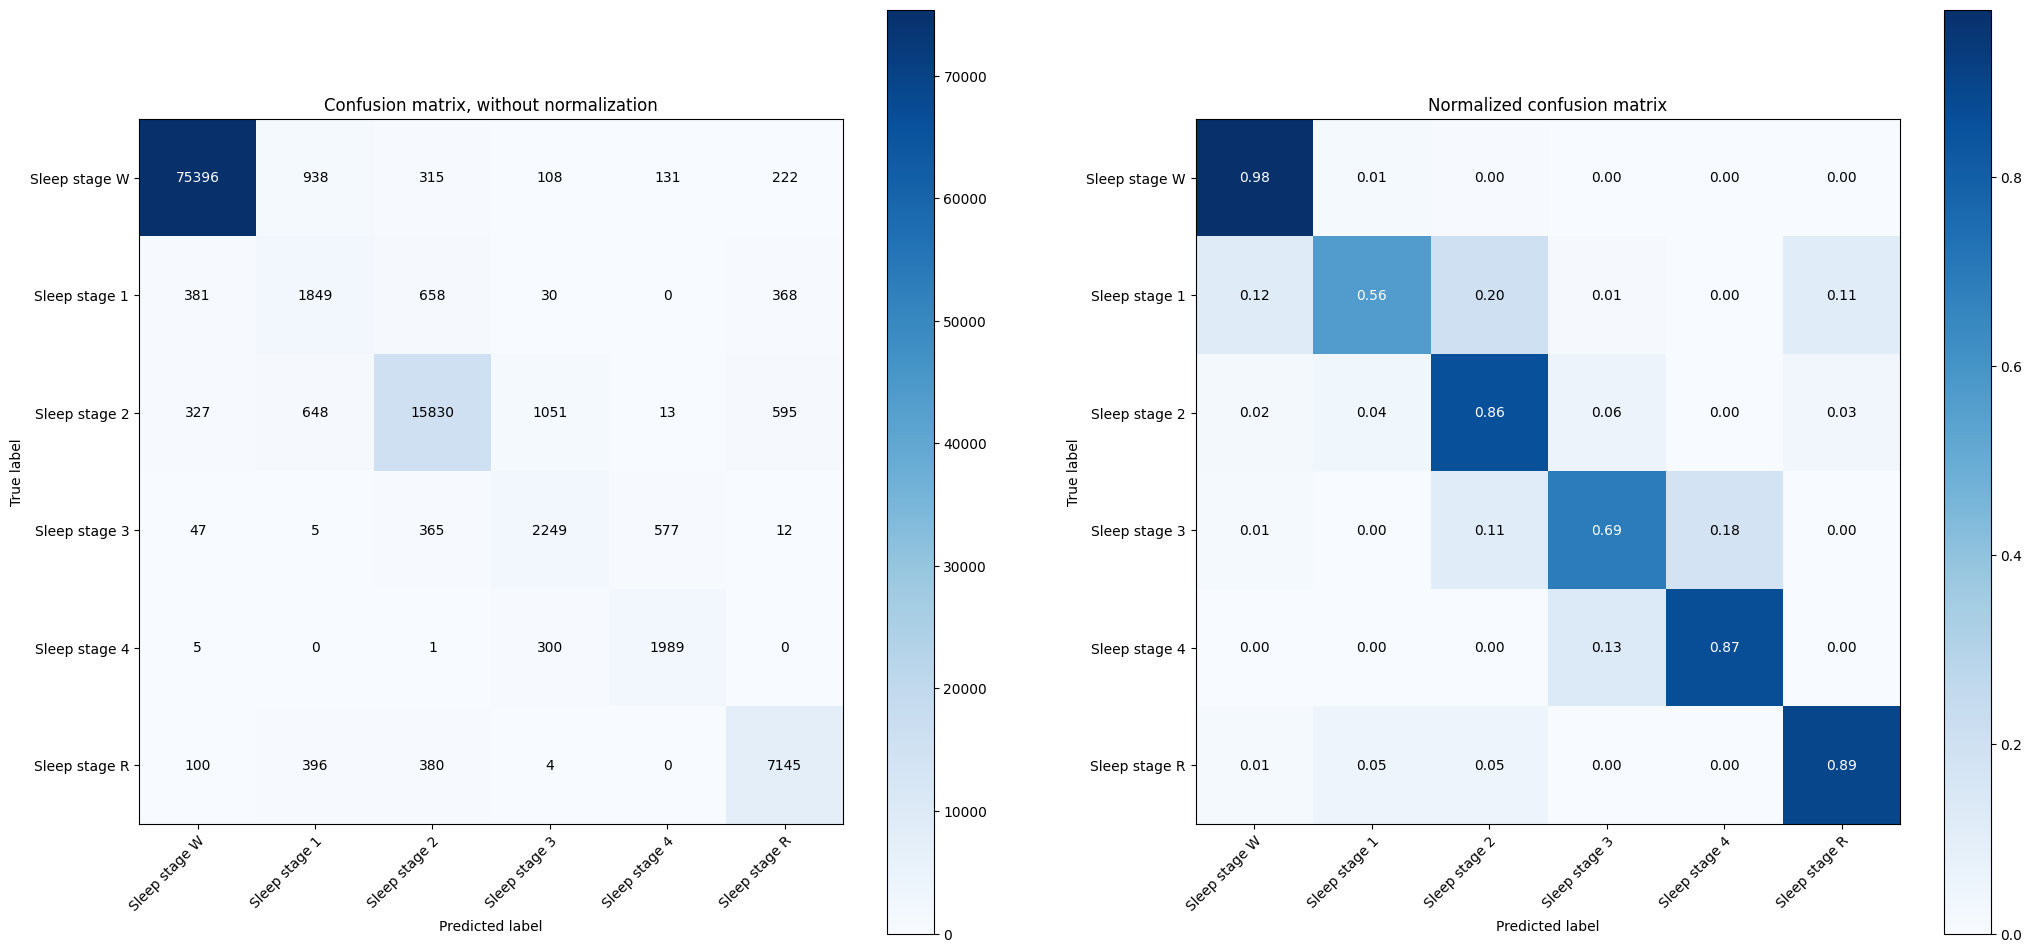

In [86]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage 4',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

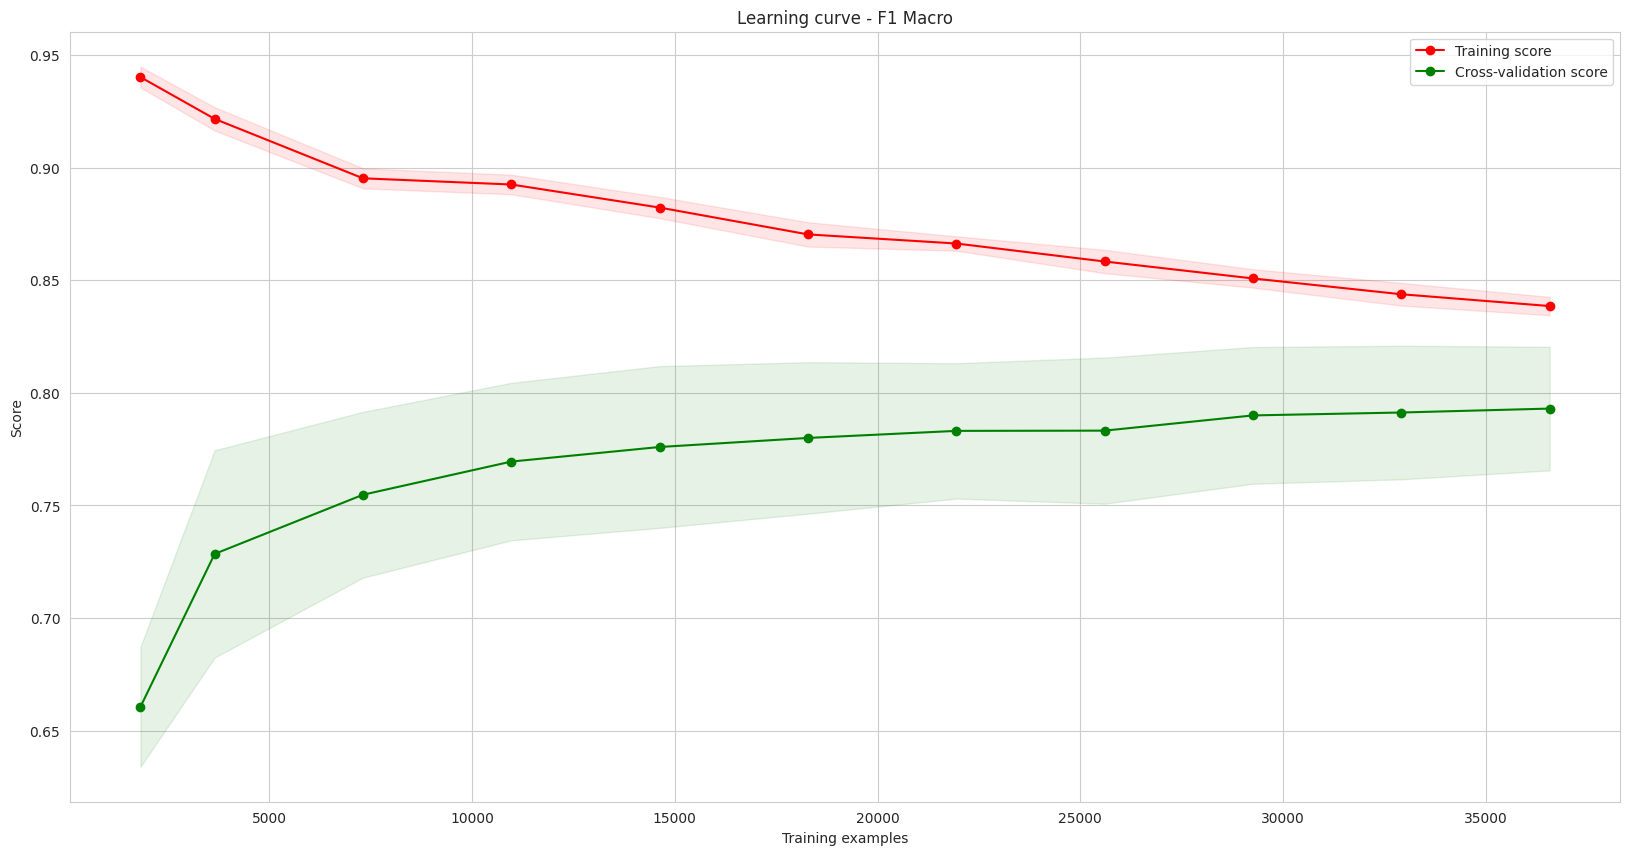

In [88]:
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed_all[feat_cols],
    y=df_feats_trimmed_all["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=8,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

## The simple, catboost pipeline

In [97]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

In [98]:
### Fit the pipeline
pipe.fit(df_feats_trimmed_all[feat_cols], df_feats_trimmed_all["label"])
print("Training data:")
preds = pipe.predict(df_feats_trimmed_all[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_all[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_all["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_all["label"], y_pred=preds))

KeyboardInterrupt: 

### Grouped 22-fold for all the data

In [88]:
df_feats.patient_id.nunique()

23

In [90]:
# Total of 5 folds
gkfold = GroupKFold(n_splits=5)
cv = gkfold.split(df_feats_trimmed_all, groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=8,
    return_train_score=True,
    return_estimator=True,
)

In [91]:
print("5-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

5-FOLD: TRAIN
  MACRO F1:           0.9077
  Balanced accuracy:  0.8968
  Accuracy:           0.9357
  Log loss:           0.1981


In [92]:
print("5-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

5-FOLD: TEST
  MACRO F1:           0.7539
  Balanced accuracy:  0.7498
  Accuracy:           0.828
  Log loss:           0.4587


In [97]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [98]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8581114640146162
ACC: 0.9523102236847957
KAPPA: 0.9047824185140676
LOG LOSS: 0.14711959724036566


In [81]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.52      0.63      0.57      3019
Sleep stage 2       0.89      0.85      0.87     20945
Sleep stage 3       0.77      0.81      0.79      6091
Sleep stage R       0.86      0.89      0.88      8094
Sleep stage W       0.88      0.85      0.86      4607

     accuracy                           0.84     42756
    macro avg       0.79      0.81      0.80     42756
 weighted avg       0.84      0.84      0.84     42756


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

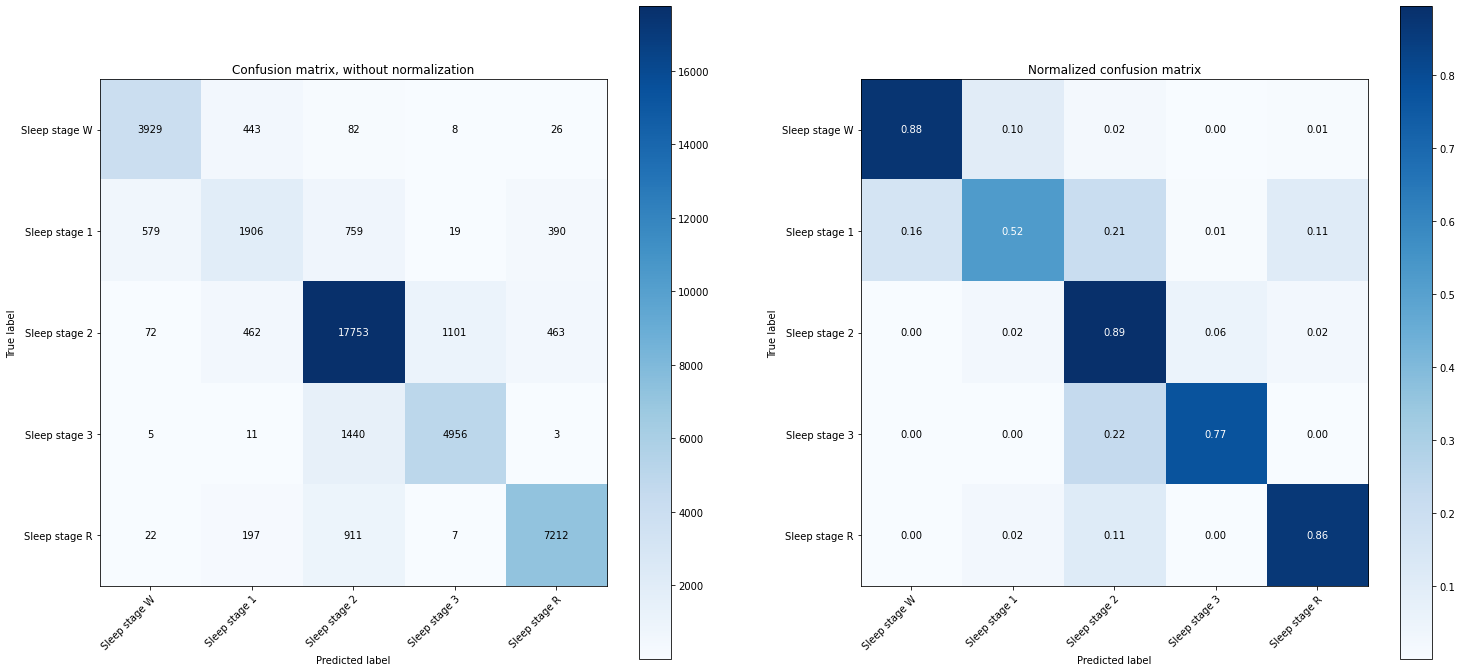

In [82]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage 4',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)